# First Order Tikhonov

In [1]:
using RegularizedSystems
using VSTom
using PyPlot

using ProgressMeter

  likely near /home/lstagner/.julia/v0.4/NetCDF/src/NetCDF.jl:438
  likely near /home/lstagner/.julia/v0.4/NetCDF/src/NetCDF.jl:438
 in depwarn at deprecated.jl:73
 in call at deprecated.jl:50
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in require at ./loading.jl:243
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in require at ./loading.jl:243
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /home/lstagner/.julia/v0.4/IJulia/src/execute_request.jl:177
 in eventloop at /home/lstagner/.julia/v0.4/IJulia/src/IJulia.jl:141
 in anonymous at task.jl:447
while loading /home/lstagner/.julia/v0.4/NetCDF/src/NetCDF.jl, in expression starting on line 429
  likely near /home/lstagner/.julia/v0.4/NetCDF/src/NetCDF.jl:429
  likely near /home/lstagner/.julia/v0.4/NetCDF/src/NetCDF.jl:429
  likely near /home/lstagner/.julia/v0.4/NetCDF/src/NetCDF.jl:429
 

In [2]:
function make_synthetic_data{T<:Real}(A::Array{T,2},dist::Array{T,2},n::T,b::T,dE::T,dP::T)
    y = (dE*dP) * (A*vec(dist))
    
    scale = n*mean(sqrt(y))
    yerr = scale .* max(sqrt(y),sqrt(b)) .* randn(length(y))
    
    noisy_spectrum = y .+ yerr
    noisy_background = b .+ scale*sqrt(b).*randn(length(y))
    
    scale_est = n*mean(sqrt(abs(noisy_spectrum)))
    
    err = scale_est .* max(sqrt(abs(noisy_spectrum)),sqrt(abs(noisy_background)))
    
    return noisy_spectrum, err
end

make_synthetic_data (generic function with 1 method)

## Reconstruct distributions on 20x20 grid

In [3]:
nenergy = 20
npitch = 20

test_dists = read_ncdf("data/test_distributions.cdf");
test_data = read_ncdf("data/test_data.cdf")
wf   = read_ncdf("data/reduced_synthetic_transfer_matrix.cdf");

A_full = wf["transfer_matrix"]
energy_full = wf["energy"]
pitch_full  = wf["pitch"]

dE_full = abs(energy_full[2] - energy_full[1])
dP_full = abs(pitch_full[2] - pitch_full[1])
energy = linspace(20.0,maximum(energy_full),nenergy)
pitch = linspace(extrema(pitch_full)...,npitch)
A = resize_transfer_matrix(A_full,energy_full,pitch_full,energy,pitch);
dE = abs(energy[2]-energy[1])
dP = abs(pitch[2]-pitch[1]);
L1E,L1p = gradEP(energy,pitch);

  likely near In[3]:4
  likely near In[3]:4
  likely near In[3]:4
  likely near In[3]:4
  likely near In[3]:4
  likely near In[3]:4
  likely near In[3]:4
  likely near In[3]:4
  likely near In[3]:4
  likely near In[3]:4
  likely near In[3]:4
  likely near In[3]:4
  likely near In[3]:4
  likely near In[3]:4
  likely near In[3]:4
  likely near In[3]:4
  likely near In[3]:4
  likely near In[3]:4
  likely near In[3]:4
  likely near In[3]:4
  likely near In[3]:4
  likely near In[3]:4
  likely near In[3]:4
  likely near In[3]:4
  likely near In[3]:4
  likely near In[3]:4
  likely near In[3]:4
  likely near In[3]:4
  likely near In[3]:4
  likely near In[3]:4
  likely near In[3]:4
  likely near In[3]:4
  likely near In[3]:4
  likely near In[3]:4
  likely near In[3]:4
  likely near In[3]:4
  likely near In[3]:4
  likely near In[3]:4
  likely near In[3]:4
  likely near In[3]:4
  likely near In[3]:4
  likely near In[3]:4
  likely near In[3]:4
  likely near In[3]:4
  likely near In[3]:4
  likely n

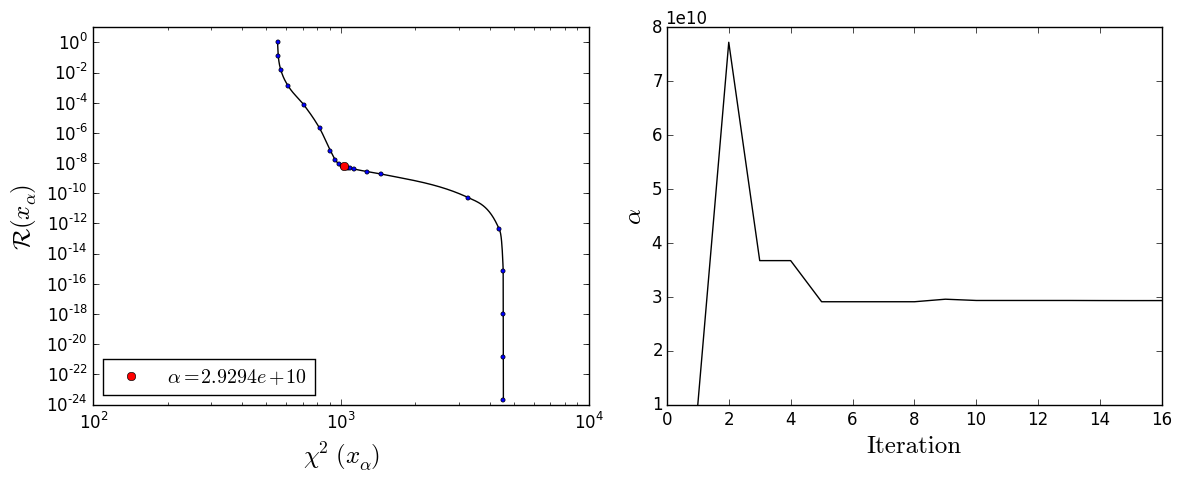

2.9294421123699326e10

In [4]:
transp_full = test_dists["transp"]
transp = bilinear(transp_full,energy_full,pitch_full,energy,pitch)
transp_vec = vec(transp)
nr,nc = size(A)
spec, err = make_synthetic_data(A_full,transp_full,0.5,1.25e14,dE_full,dP_full)
RF = TikhonovFunctional(A,spec,err,(L1E,L1p))
alpha = lcurve(RF,log_alpha_range=(0,20),nseeds=15,doplot=true,filename="tik1_transp_k=0.5_lcurve.eps")

In [4]:
function tik1_analysis(A_full,dist_full,dE_full,dP_full,A,dE,dP,L1E,L1p,n;num=20)
    nr,nc = size(A)
    x = zeros(nc,num)
    for i=1:num
        spec,err = make_synthetic_data(A_full,dist_full,n,1.25e14,dE_full,dP_full)
        RF = TikhonovFunctional(A,spec,err,(L1E,L1p))
        alpha = lcurve(RF,log_alpha_range=(0,20),nseeds=20)
        sol = minimize(RF,alpha)
        x[:,i] = max(sol.x,0)/(dE*dP)
    end
    
    return x
end

tik1_analysis (generic function with 1 method)

In [7]:
transp_full = test_dists["transp"]
transp = bilinear(transp_full,energy_full,pitch_full,energy,pitch)
transp_vec = vec(transp)
nr,nc = size(A)
t_x_mean = zeros(nc,20)
t_x_var = zeros(nc,20)
t_x_bias = zeros(nc,20)
t_x_mse = zeros(nc,20)

t_d_mean = zeros(20)
t_d_var = zeros(20)
t_d_bias = zeros(20)
t_d_mse = zeros(20)

@showprogress for (i,n) in enumerate(0.05:0.05:1.0)
    x_samples = tik1_analysis(A_full,transp_full,dE_full,dP_full,A,dE,dP,L1E,L1p,n)

    t_x_mean[:,i] = squeeze(mean(x_samples,2),2)
    t_x_var[:,i] = squeeze(var(x_samples,2),2)
    t_x_bias[:,i] = t_x_mean[:,i] - transp_vec
    t_x_mse[:,i] = t_x_bias[:,i].^2 + t_x_var[:,i]
    
    t_d_mean[i] = mean(sum(x_samples,1)*dE*dP)
    t_d_var[i] = var(sum(x_samples,1)*dE*dP)
    t_d_bias[i] = t_d_mean[i] - 1e12
    t_d_mse[i] = t_d_bias[i]^2 + t_d_var[i]
end

Progress: 100%|█████████████████████████████████████████| Time: 0:38:19


In [30]:
x_samples = tik1_analysis(A_full,transp_full,dE_full,dP_full,A,dE,dP,L1E,L1p,1.0)
i=20
t_x_mean[:,i] = squeeze(mean(x_samples,2),2)
t_x_var[:,i] = squeeze(var(x_samples,2),2)
t_x_bias[:,i] = t_x_mean[:,i] - transp_vec
t_x_mse[:,i] = t_x_bias[:,i].^2 + t_x_var[:,i]

t_d_mean[i] = mean(sum(x_samples,1)*dE*dP)
t_d_var[i] = var(sum(x_samples,1)*dE*dP)
t_d_bias[i] = t_d_mean[i] - 1e12
t_d_mse[i] = t_d_bias[i]^2 + t_d_var[i]

1.106607809643944e23

In [32]:
using NetCDF
# Write synthetic data to file
fname = "data/tik1_sampled_transp.cdf"

isfile(fname) && rm(fname)

nrows_id = NcDim("nrows",20*20)
ncols_id = NcDim("ncols",20)
nen_id = NcDim("nenergy",20)
np_id = NcDim("npitch",20)

x_mean_varid = NcVar("x_mean",[nrows_id,ncols_id])
x_var_varid = NcVar("x_var",[nrows_id,ncols_id])
x_bias_varid = NcVar("x_bias",[nrows_id,ncols_id])
x_mse_varid = NcVar("x_mse",[nrows_id,ncols_id])

d_mean_varid = NcVar("d_mean",ncols_id)
d_var_varid = NcVar("d_var",ncols_id)
d_bias_varid = NcVar("d_bias",ncols_id)
d_mse_varid = NcVar("d_mse",ncols_id)

energy_varid = NcVar("energy",nen_id)
pitch_varid = NcVar("pitch",nen_id)
elevel_varid = NcVar("error_level",ncols_id)

ncid = NetCDF.create(fname,[x_mean_varid,x_var_varid,x_bias_varid,x_mse_varid,
    d_mean_varid,d_var_varid,d_bias_varid,d_mse_varid,energy_varid,pitch_varid,elevel_varid],mode=NC_CLASSIC_MODEL)

NetCDF.putvar(ncid,"x_mean",t_x_mean)
NetCDF.putvar(ncid,"x_var",t_x_var)
NetCDF.putvar(ncid,"x_bias",t_x_bias)
NetCDF.putvar(ncid,"x_mse",t_x_mse)

NetCDF.putvar(ncid,"d_mean",t_d_mean)
NetCDF.putvar(ncid,"d_var",t_d_var)
NetCDF.putvar(ncid,"d_bias",t_d_bias)
NetCDF.putvar(ncid,"d_mse",t_d_mse)

NetCDF.putvar(ncid,"energy",energy)
NetCDF.putvar(ncid,"pitch",pitch)
NetCDF.putvar(ncid,"error_level",[0.05:0.05:1.0])
NetCDF.close(ncid);

In [33]:
gaussian_full = test_dists["gaussian"]
gaussian = bilinear(gaussian_full,energy_full,pitch_full,energy,pitch)
gaussian_vec = vec(gaussian)
nr,nc = size(A)
g_x_mean = zeros(nc,20)
g_x_var = zeros(nc,20)
g_x_bias = zeros(nc,20)
g_x_mse = zeros(nc,20)

g_d_mean = zeros(20)
g_d_var = zeros(20)
g_d_bias = zeros(20)
g_d_mse = zeros(20);

In [36]:
@showprogress for (i,n) in enumerate(0.05:0.05:1.0)
    x_samples = tik1_analysis(A_full,gaussian_full,dE_full,dP_full,A,dE,dP,L1E,L1p,n)

    g_x_mean[:,i] = squeeze(mean(x_samples,2),2)
    g_x_var[:,i] = squeeze(var(x_samples,2),2)
    g_x_bias[:,i] = g_x_mean[:,i] - gaussian_vec
    g_x_mse[:,i] = g_x_bias[:,i].^2 + g_x_var[:,i]
    
    g_d_mean[i] = mean(sum(x_samples,1)*dE*dP)
    g_d_var[i] = var(sum(x_samples,1)*dE*dP)
    g_d_bias[i] = g_d_mean[i] - 1e12
    g_d_mse[i] = g_d_bias[i]^2 + g_d_var[i]
end

Progress: 100%|█████████████████████████████████████████| Time: 0:53:19


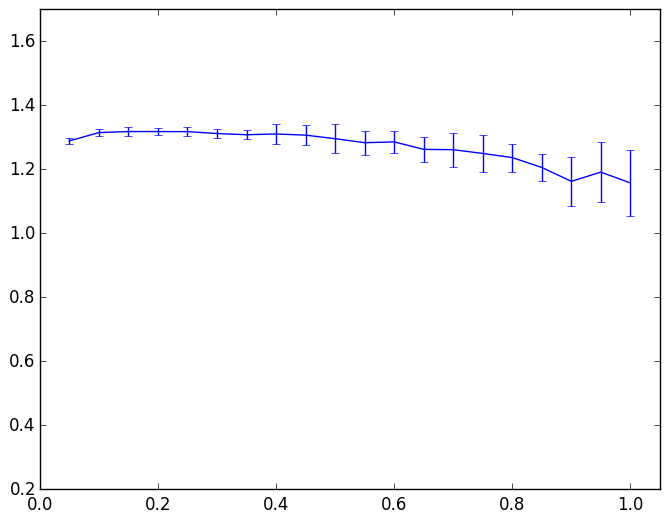

(0,1.05)

In [38]:
errorbar([0.05:0.05:1.0],g_d_mean/1e12,sqrt(g_d_var)/1e12)
ylim(0.2,1.7)
xlim(0,1.05)

In [39]:
using NetCDF
# Write synthetic data to file
fname = "data/tik1_sampled_gaussian.cdf"

isfile(fname) && rm(fname)

nrows_id = NcDim("nrows",20*20)
ncols_id = NcDim("ncols",20)
nen_id = NcDim("nenergy",20)
np_id = NcDim("npitch",20)

x_mean_varid = NcVar("x_mean",[nrows_id,ncols_id])
x_var_varid = NcVar("x_var",[nrows_id,ncols_id])
x_bias_varid = NcVar("x_bias",[nrows_id,ncols_id])
x_mse_varid = NcVar("x_mse",[nrows_id,ncols_id])

d_mean_varid = NcVar("d_mean",ncols_id)
d_var_varid = NcVar("d_var",ncols_id)
d_bias_varid = NcVar("d_bias",ncols_id)
d_mse_varid = NcVar("d_mse",ncols_id)

energy_varid = NcVar("energy",nen_id)
pitch_varid = NcVar("pitch",nen_id)
elevel_varid = NcVar("error_level",ncols_id)

ncid = NetCDF.create(fname,[x_mean_varid,x_var_varid,x_bias_varid,x_mse_varid,
    d_mean_varid,d_var_varid,d_bias_varid,d_mse_varid,energy_varid,pitch_varid,elevel_varid],mode=NC_CLASSIC_MODEL)

NetCDF.putvar(ncid,"x_mean",g_x_mean)
NetCDF.putvar(ncid,"x_var",g_x_var)
NetCDF.putvar(ncid,"x_bias",g_x_bias)
NetCDF.putvar(ncid,"x_mse",g_x_mse)

NetCDF.putvar(ncid,"d_mean",g_d_mean)
NetCDF.putvar(ncid,"d_var",g_d_var)
NetCDF.putvar(ncid,"d_bias",g_d_bias)
NetCDF.putvar(ncid,"d_mse",g_d_mse)

NetCDF.putvar(ncid,"energy",energy)
NetCDF.putvar(ncid,"pitch",pitch)
NetCDF.putvar(ncid,"error_level",[0.05:0.05:1.0])
NetCDF.close(ncid);

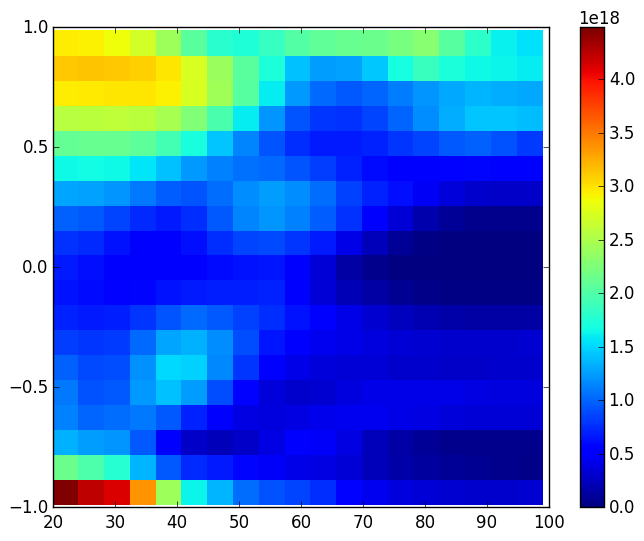

PyObject <matplotlib.colorbar.Colorbar object at 0x7f6d5ef4f240>

In [45]:
pcolor(energy,pitch,reshape(t_x_var[:,15],20,20))
colorbar()

In [5]:
bimax_full = test_dists["bimax"]
bimax = bilinear(bimax_full,energy_full,pitch_full,energy,pitch)
bimax_vec = vec(bimax)
nr,nc = size(A)
b_x_mean = zeros(nc,20)
b_x_var = zeros(nc,20)
b_x_bias = zeros(nc,20)
b_x_mse = zeros(nc,20)

b_d_mean = zeros(20)
b_d_var = zeros(20)
b_d_bias = zeros(20)
b_d_mse = zeros(20);

In [6]:
@showprogress for (i,n) in enumerate(0.05:0.05:1.0)
    x_samples = tik1_analysis(A_full,bimax_full,dE_full,dP_full,A,dE,dP,L1E,L1p,n)

    b_x_mean[:,i] = squeeze(mean(x_samples,2),2)
    b_x_var[:,i] = squeeze(var(x_samples,2),2)
    b_x_bias[:,i] = b_x_mean[:,i] - bimax_vec
    b_x_mse[:,i] = b_x_bias[:,i].^2 + b_x_var[:,i]
    
    b_d_mean[i] = mean(sum(x_samples,1)*dE*dP)
    b_d_var[i] = var(sum(x_samples,1)*dE*dP)
    b_d_bias[i] = b_d_mean[i] - 1e12
    b_d_mse[i] = b_d_bias[i]^2 + b_d_var[i]
end

Progress: 100%|█████████████████████████████████████████| Time: 0:40:01


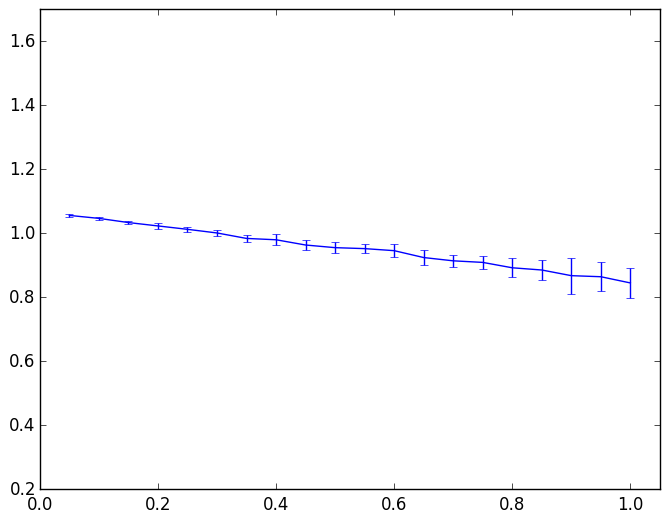

(0,1.05)

In [7]:
errorbar([0.05:0.05:1.0],b_d_mean/1e12,sqrt(b_d_var)/1e12)
ylim(0.2,1.7)
xlim(0,1.05)

In [8]:
using NetCDF
# Write synthetic data to file
fname = "data/tik1_sampled_bimax.cdf"

isfile(fname) && rm(fname)

nrows_id = NcDim("nrows",20*20)
ncols_id = NcDim("ncols",20)
nen_id = NcDim("nenergy",20)
np_id = NcDim("npitch",20)

x_mean_varid = NcVar("x_mean",[nrows_id,ncols_id])
x_var_varid = NcVar("x_var",[nrows_id,ncols_id])
x_bias_varid = NcVar("x_bias",[nrows_id,ncols_id])
x_mse_varid = NcVar("x_mse",[nrows_id,ncols_id])

d_mean_varid = NcVar("d_mean",ncols_id)
d_var_varid = NcVar("d_var",ncols_id)
d_bias_varid = NcVar("d_bias",ncols_id)
d_mse_varid = NcVar("d_mse",ncols_id)

energy_varid = NcVar("energy",nen_id)
pitch_varid = NcVar("pitch",nen_id)
elevel_varid = NcVar("error_level",ncols_id)

ncid = NetCDF.create(fname,[x_mean_varid,x_var_varid,x_bias_varid,x_mse_varid,
    d_mean_varid,d_var_varid,d_bias_varid,d_mse_varid,energy_varid,pitch_varid,elevel_varid],mode=NC_CLASSIC_MODEL)

NetCDF.putvar(ncid,"x_mean",b_x_mean)
NetCDF.putvar(ncid,"x_var",b_x_var)
NetCDF.putvar(ncid,"x_bias",b_x_bias)
NetCDF.putvar(ncid,"x_mse",b_x_mse)

NetCDF.putvar(ncid,"d_mean",b_d_mean)
NetCDF.putvar(ncid,"d_var",b_d_var)
NetCDF.putvar(ncid,"d_bias",b_d_bias)
NetCDF.putvar(ncid,"d_mse",b_d_mse)

NetCDF.putvar(ncid,"energy",energy)
NetCDF.putvar(ncid,"pitch",pitch)
NetCDF.putvar(ncid,"error_level",[0.05:0.05:1.0])
NetCDF.close(ncid);